In [1]:
import cv2
import os
from os import path
from glob import glob
os.chdir('../')
import mmcv
import lmdb
from mmcls.apis import inference_model, init_model
from mmcls.datasets.pipelines import Compose
from mmcv.parallel import collate, scatter
from mmcls.models import build_classifier

/home/xumingjie/miniconda3/envs/open-mmlab/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

from lib.preprocess_utils import show_img, read_resize_img, crop_borders, segment_breast, horizontal_flip,convert_to_16bit

ModuleNotFoundError: No module named 'lib'

In [ ]:
def process_pipeline(img_file_path):
    target_height, target_width = (1120,896)
    img = read_resize_img(img_file_path, )
    img = crop_borders(img,border_size=(0,0,0.06,0.06,))
    img_segment,_,breast_mask = segment_breast(img)
    img_filped = horizontal_flip(img_segment,breast_mask)
    img_resized = cv2.resize(img_filped,dsize=(target_width, target_height), 
            interpolation=cv2.INTER_CUBIC)
    img_resized = convert_to_16bit(img_resized)
    return img_resized

In [ ]:
config = mmcv.Config.fromfile('/home/xumingjie/Desktop/MulitTasksBreastCancerPred/configs/patch_models/resnet_inference_config.py')
model = build_classifier(config.model)
model.init_weights()
model.cfg = config  # save the config in the model for convenience
model.to('cuda:0')
model.eval()

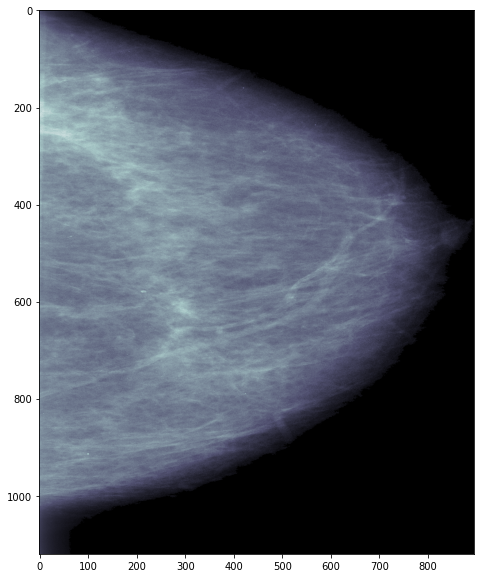

In [ ]:
img = process_pipeline('/home/xumingjie/Desktop/DDSM_DATA/cbis-ddsm-png/full_mammogram_images/Calc-Test_P_00038_LEFT_CC.png')
show_img(img)

In [ ]:

cfg = model.cfg
device = next(model.parameters()).device  # model device
# build the data pipeline
data = dict(img=img)
test_pipeline = Compose(cfg.data.test.pipeline)
data = test_pipeline(data)
data = collate([data], samples_per_gpu=1)
if next(model.parameters()).is_cuda:
    # scatter to specified GPU
    data = scatter(data, [device])[0]

In [7]:

# test a single image
scores = model(return_loss=False, **data)

In [8]:
scores

[array([9.62904990e-01, 1.28199225e-02, 3.90196743e-04, 2.35059019e-02,
        3.79064732e-04], dtype=float32)]